In [62]:
from cnn_model import *
from cnn_image import *
from evaluation import *

In [63]:
import time

import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [64]:
import os
from evaluation import *

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# desired size of the output im
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

In [66]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)
    return path

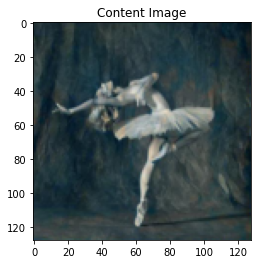

In [67]:
content_img = image_loader("picasso2.jpg")

plt.figure()
imshow(content_img, title='Content Image')

In [68]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [69]:
def get_imgs_name(file):
    """ Get images name form a txt file

    input:
        file (str): name of the txt file
        path: prefix of the system path

    output:
        names (list): the name of this type of img
        imgs (list): a list store the path of the image
    """
    styles = []
    names = []
    imgs = []

    with open(file, 'r') as f:
        for line in f.readlines():
            s = line.strip('\n').split('/')
            styles.append(s[0])
            s = ''.join(s[1:])
            imgs.append(s)
            names.append(s[:-4])

    return styles, names, imgs

In [70]:
# desired depth layers to compute style/content losses:
default_content_layers = ['conv_4']
default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [71]:
def tansfer(cnn, content_img, style_name, style_img, file,
            num_output = 5,
            default_content_layers = ['conv_4'],
            default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    """
    
    input:
        cnn: the pre train model.
        content_img (tensor)
        style_name (str): like 'blotchy_0003'
        style_img (tensor)
    output:
        out_imgs: the group of new generation pictures
    """
    out_imgs = []
    scores = 0

    # store the style image
    org_image = copy.deepcopy(style_img)
    torchvision.utils.save_image(org_image, file + '/' + style_name + '_0.jpg')

    for i in range(num_output):
        input_img = generate_input_image(noise = True, content_img=content_img)

        output, g, times = style_transfer(cnn, content_img, style_img, input_img,
        default_mean_std = False, 
        num_steps=100, 
        style_weight=1000000, 
        content_weight=2)
        times.append(time)
        
        # save fig
        out_imgs.append(output)
        save_name = '{}_{}'.format(style_name, i + 1)
        torchvision.utils.save_image(output, file + '/{}.jpg'.format(save_name))

     
    # times = np.mean(times, 0)
    # plot the time
    plt.figure()
    plt.scatter(range(len(times))[::10], times[::10], 
        marker='x', linewidths=1, label = style_name)
    plt.xlabel('Iteration Times')
    plt.ylabel('Running Time')
    plt.title(style_name)
    plt.legend()
    plt.savefig(file + '/{} time'.format(style_name))

    return out_imgs

In [72]:
def generate_compare(cnn, content_img, txt_file, saving_path,
            img_path = '../src/dtd/images/',
            num_output = 5,
            default_content_layers = ['conv_4'],
            default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
            """
            input: 
                content_img (tensor)
                txt_file (str): store the texture we want to generate
                saving_path (str): the path we want to save our pictures
            """

            styles, names, imgs = get_imgs_name(txt_file)

    
            for style, name, img in zip(styles, names, imgs):
                #this_saving_path = saving_path + '/' + name
                style_name = style
                img_name = name

                style_img = image_loader(img_path + style + '/'+ img)

                save_folder = mkdir(saving_path + img_name)
 
                out_images = tansfer(cnn, 
                                     content_img, 
                                     img_name, 
                                     style_img,
                                     save_folder,
                                     num_output)

                loss = 0
                for out in out_images:
                    loss += evaluation(cnn, style_img, out)
                loss /= len(out_images)
                loss = round(loss, 4)

                with open(join(saving_path, '/scores','/scores'),'a+') as f:
                    f.write(img_name + ' ' + str(loss) + '\n')

In [73]:
txt_file = '../test/test.txt'

In [74]:
generate_compare(cnn, content_img, 
                #txt_file = '../test/test_blotchy1.txt',
                txt_file = txt_file, 
                saving_path = '../transfered_output/',
                num_output = 2,
                default_content_layers = ['conv_4'],
                default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1827.804321 Content Loss: 115.170242

run [100]:
Style Loss : 683.993164 Content Loss: 113.651413

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1871.133057 Content Loss: 115.416985

run [100]:
Style Loss : 656.036194 Content Loss: 114.612762



KeyboardInterrupt: 